In [7]:
# Installing the required libraries
import os
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from joblib import Parallel, delayed
import mapclassify

### Steps: 
1. **Load Census Tracts and Taxi Zones:**
    * Load the shapefiles for census tracts and taxi zones.
    * Ensure the merged GeoDataFrame contains population density information for each census tract.

2. **Rasterize Census Tracts:**
    * Convert the census tracts into a raster grid where each pixel represents the population density.
    
3. **Zonal Sum for Taxi Zones:**
    * Sum the rasterized population densities within the boundary of each taxi zone.
    * Calculate the average population density for each taxi zone.

In [2]:
# Loading the shape file for tax zones
current_dir = os.getcwd()
shapefile_path = os.path.join(current_dir, '..', 'data', 'NYC Taxi Zones', 'geo_export_5d80cfbe-13fc-4d7a-a530-e88bb7a8d4ee.shp')
taxi_zones = gpd.read_file(shapefile_path)
taxi_zones = taxi_zones.to_crs(epsg=4326)
taxi_zones.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


In [25]:
# Importing the merged shape file with population density data
merged_shapefile_path = os.path.join(current_dir, '..', 'data', 'nyc_censust_pop_density_out', 'nyc_census_tracts_with_population.shp')
merged_shapefile = gpd.read_file(merged_shapefile_path)
merged_shapefile = merged_shapefile.to_crs(epsg=4326)

# Calculate the population density and add it as a column
merged_shapefile['population_density'] = merged_shapefile['P1_001N'] / (merged_shapefile['Shape_Area'])  # Assuming Shape_Area is in m^2

merged_shapefile.columns


Index(['CTLabel_x', 'BoroCode_x', 'BoroName', 'CT2020', 'BoroCT2020',
       'CDEligibil', 'NTAName', 'NTA2020', 'CDTA2020', 'CDTANAME', 'GEOID',
       'PUMA', 'Shape_Leng', 'Shape_Area', 'Key', 'P1_001N', 'NAME', 'state',
       'county', 'tract', 'CTLabel_y', 'County_1', 'StateName', 'Borough',
       'BoroCode_y', 'CTLabelNum', 'geometry', 'population_density'],
      dtype='object')

In [26]:
# Define the output raster grid parameters
minx, miny, maxx, maxy = merged_shapefile.total_bounds
pixel_size = 0.0001  # Adjust the pixel size as needed
width = int((maxx - minx) / pixel_size)
height = int((maxy - miny) / pixel_size)

print(f"min-x: {minx}, min-y: {miny}, max-x: {maxx}, max-y: {maxy}")
print(f"Raster dimensions: width={width}, height={height}")

min-x: -74.25559136315213, min-y: 40.49613398761199, max-x: -73.70000906321272, max-y: 40.91553277650282
Raster dimensions: width=5555, height=4193


In [27]:
# Ensure width and height are positive
if width <= 0 or height <= 0:
    raise ValueError("Calculated width and height must be > 0")

# Create an empty raster array
raster = np.zeros((height, width))

# Define a function to get population density for rasterization
def get_density(geometry, value):
    return [(geometry, value)]

# Rasterize the census tracts
transform = rasterio.transform.from_bounds(minx, miny, maxx, maxy, width, height)
for _, row in merged_shapefile.iterrows():
    shapes = get_density(row['geometry'], row['population_density'])
    raster += rasterize(shapes, out_shape=(height, width), transform=transform)


In [ ]:
# PARALLEL PROCESSING CODE
# Ensure width and height are positive
if width <= 0 or height <= 0:
    raise ValueError("Calculated width and height must be > 0")

# Create an empty raster array
raster = np.zeros((height, width))

# Define a function to get population density for rasterization
def get_density(geometry, value):
    return [(geometry, value)]

# Function to rasterize a chunk of the GeoDataFrame
def rasterize_chunk(chunk, transform, out_shape):
    temp_raster = np.zeros(out_shape)
    for _, row in chunk.iterrows():
        shapes = get_density(row['geometry'], row['population_density'])
        temp_raster += rasterize(shapes, out_shape=out_shape, transform=transform)
    return temp_raster

# Split the merged_shapefile into chunks for parallel processing
num_chunks = 8  # Adjust the number of chunks based on your system's capabilities
chunks = np.array_split(merged_shapefile, num_chunks)

# Rasterize the chunks in parallel
raster_chunks = Parallel(n_jobs=-1)(delayed(rasterize_chunk)(chunk,\
    rasterio.transform.from_bounds(minx, miny, maxx, maxy, width, height), \
    (height, width)) for chunk in chunks)

# Combine the raster chunks
for temp_raster in raster_chunks:
    raster += temp_raster

**Parallel chunk takes more time for now - maybe there are gains to be made with scale**

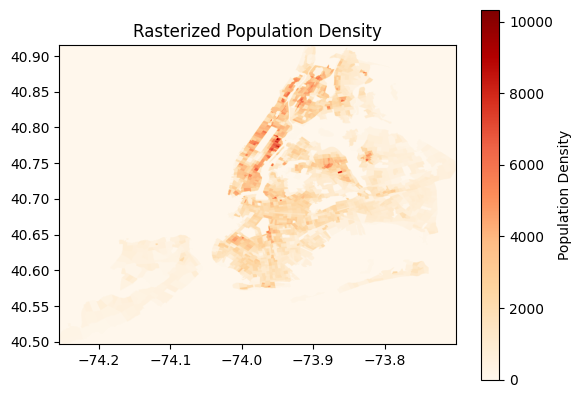

In [28]:
# Visualize the raster
plt.imshow(raster, cmap='OrRd', extent=(minx, maxx, miny, maxy))
plt.colorbar(label='Population Density')
plt.title('Rasterized Population Density')
plt.show()

In [29]:
# Convert the numpy array to an xarray DataArray
raster_da = xr.DataArray(raster, dims=("y", "x"))
raster_da.rio.write_transform(transform, inplace=True)
raster_da.rio.write_crs("EPSG:4326", inplace=True)

# Perform zonal statistics to calculate population density for each taxi zone
taxi_zones['mean_population_density'] = None

def calculate_mean_density(zone_geom):
    masked = raster_da.rio.clip([zone_geom])
    return masked.mean().item()

for idx, row in taxi_zones.iterrows():
    zone_geom = row['geometry']
    mean_density = calculate_mean_density(zone_geom)
    taxi_zones.at[idx, 'mean_population_density'] = mean_density

In [30]:
# Check the results
taxi_zones.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   borough                  263 non-null    object  
 1   location_i               263 non-null    float64 
 2   objectid                 263 non-null    float64 
 3   shape_area               263 non-null    float64 
 4   shape_leng               263 non-null    float64 
 5   zone                     263 non-null    object  
 6   geometry                 263 non-null    geometry
 7   mean_population_density  263 non-null    object  
dtypes: float64(4), geometry(1), object(3)
memory usage: 16.6+ KB


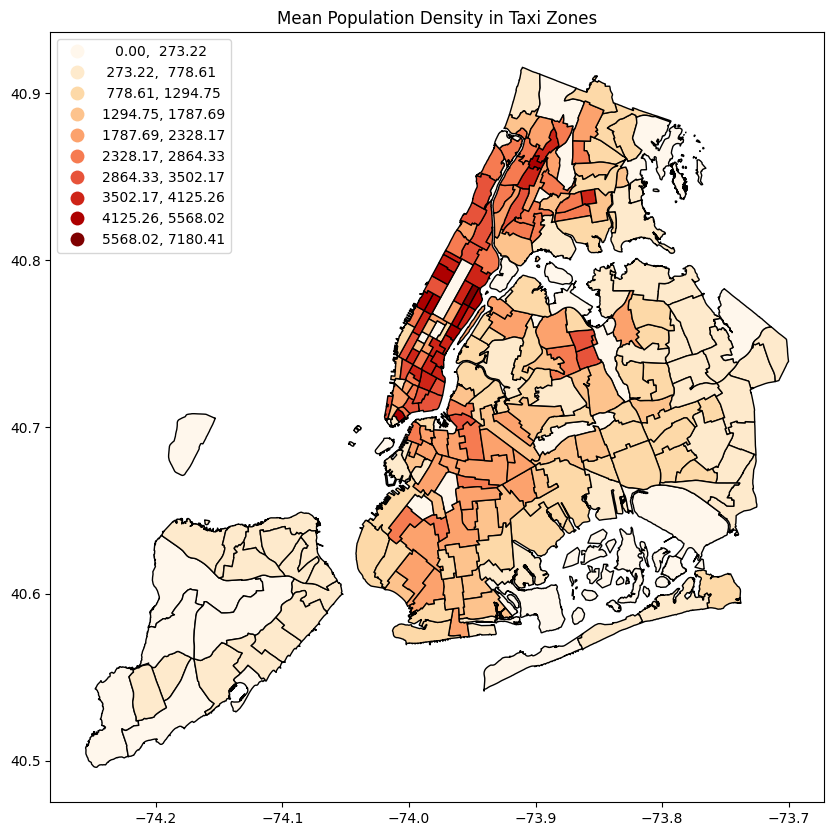

In [32]:
# Plot the taxi zones colored by mean population density

# Define the number of classes for binning the data
num_classes = 10

# Create a classifier
classifier = mapclassify.NaturalBreaks(merged_shapefile['population_density'], k=num_classes)

# Plot the taxi zones colored by mean population density with classification and a better color scheme
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
taxi_zones.plot(column='mean_population_density', cmap='OrRd', edgecolor='k',scheme='NaturalBreaks', k=num_classes,
                legend=True, ax= ax, legend_kwds={'loc': 'upper left'})
ax.set_title('Mean Population Density in Taxi Zones')
plt.show()